### Data wrangle

In [77]:
# Grab Data
import yfinance as yf
from datetime import datetime as dt

# Usual Suspects
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
#import matplotlib
#matplotlib.use( 'tkAgg' )

# Use PyPortfolioOpt for Calculations
from pypfopt import EfficientFrontier, objective_functions
from pypfopt import black_litterman, risk_models
from pypfopt import BlackLittermanModel, plotting
from pypfopt import DiscreteAllocation

In [78]:
# Collect user input for stock symbols

# Create a Portfolio
symbols = ['PFE','GSK','AZN','BMY','MRK','RHHBY','SNY','NVS','ABBV','JNJ']

In [79]:
# Get the stock data
# tz = pytz.timezone("America/New_York")
# start = tz.localize(dt(2000,1,1))
# end = tz.localize(dt.today())

portfolio = yf.download(symbols, period = '20y')['Adj Close']
portfolio.head()

[*********************100%%**********************]  10 of 10 completed


Ticker,ABBV,AZN,BMY,GSK,JNJ,MRK,NVS,PFE,RHHBY,SNY
Date,,,,,,,,,,
2004-04-12,NaN,10.995600,11.527501,15.598539,29.220284,20.691584,19.763014,15.470087,6.862490,15.578198
2004-04-13,NaN,10.931108,11.390326,15.419728,29.328716,20.548700,19.234587,15.348653,6.657791,15.382032
2004-04-14,NaN,10.822860,11.589001,15.415922,30.019270,20.945099,19.441362,15.530806,6.731616,15.401170
2004-04-15,NaN,11.189075,11.811314,16.230091,31.115044,21.654953,20.194941,16.194366,6.862490,15.578198
2004-04-16,NaN,11.193676,11.768745,16.199650,30.892471,21.701046,20.181154,16.315807,6.922894,15.640392


In [80]:
# SP500 ETF Benchmark
market_prices = yf.download("SPY", period = '20y')["Adj Close"]
market_prices.head()

[*********************100%%**********************]  1 of 1 completed


Date
2004-04-12    78.345520
2004-04-13    77.246933
2004-04-14    77.369766
2004-04-15    77.076355
2004-04-16    77.669983
Name: Adj Close, dtype: float64

In [81]:
# Grap Market Capitalization for each stock in portfolio
mcaps = {}
for t in symbols:
    stock = yf.Ticker(t)
    mcaps[t] = stock.info["marketCap"]
mcaps

{'PFE': 151642816512,
 'GSK': 83563626496,
 'AZN': 212099072000,
 'BMY': 104580808704,
 'MRK': 320910819328,
 'RHHBY': 197401952256,
 'SNY': 118656270336,
 'NVS': 195838509056,
 'ABBV': 301258375168,
 'JNJ': 366985379840}

### Setting up priors

In [82]:
# Calculate Sigma(S), the covariance matrix, using the Ledoit-Wolf method
# Ledoit-Wolf is a particular form of shrinkage, where the shrinkage coefficient is computed using O
S = risk_models.CovarianceShrinkage(portfolio).ledoit_wolf()
print(S)

delta = black_litterman.market_implied_risk_aversion(market_prices)
delta

Ticker      ABBV       AZN       BMY       GSK       JNJ       MRK       NVS  \
Ticker                                                                         
ABBV    0.039357  0.012359  0.015234  0.010660  0.011568  0.013484  0.010994   
AZN     0.012359  0.062205  0.024036  0.031952  0.018027  0.025099  0.026076   
BMY     0.015234  0.024036  0.056061  0.020497  0.018989  0.026830  0.018451   
GSK     0.010660  0.031952  0.020497  0.044529  0.017181  0.023748  0.023440   
JNJ     0.011568  0.018027  0.018989  0.017181  0.029170  0.022632  0.015374   
MRK     0.013484  0.025099  0.026830  0.023748  0.022632  0.062884  0.021139   
NVS     0.010994  0.026076  0.018451  0.023440  0.015374  0.021139  0.037861   
PFE     0.014252  0.025387  0.027077  0.022550  0.021710  0.030542  0.020837   
RHHBY   0.009130  0.026504  0.017550  0.022830  0.014832  0.019666  0.027147   
SNY     0.011242  0.033739  0.024781  0.030730  0.019800  0.026961  0.028866   

Ticker       PFE     RHHBY       SNY  


2.5739122797342175

<Axes: xlabel='Ticker', ylabel='Ticker'>

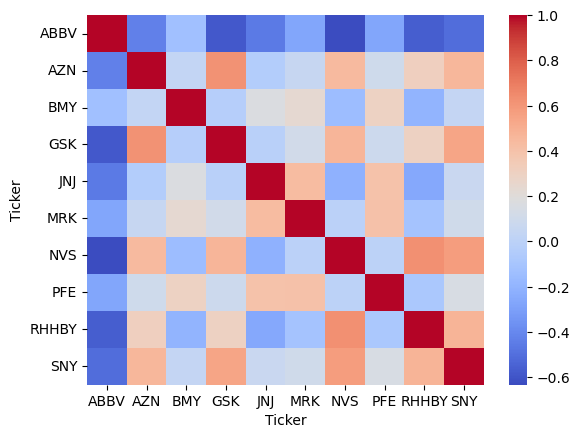

In [83]:
# Visualize the Covariant Correlation
sns.heatmap(S.corr(), cmap='coolwarm')

In [84]:
market_prior = black_litterman.market_implied_prior_returns(mcaps, delta, S)
market_prior

Ticker
ABBV     0.061355
AZN      0.088911
BMY      0.078885
GSK      0.077601
JNJ      0.070500
MRK      0.093364
NVS      0.075812
PFE      0.084773
RHHBY    0.078030
SNY      0.089170
dtype: float64

<Axes: ylabel='Ticker'>

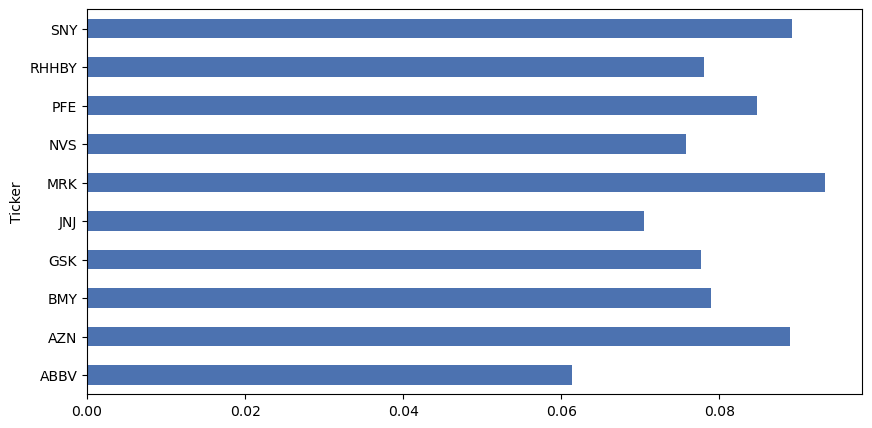

In [85]:
market_prior.plot.barh(figsize=(10,5))

### Integrating views

In [86]:
# You don't have to provide views on all the assets
# For absolute views
# Examples:
    # View 1: 'PFE' will rise by 10% 
    # View 2: 'AZN' will drop by 5%
    # View 3: 'BMY' will rise by 18%
viewdict = {'PFE': 0.1,
            'GSK': 0.1,
            'AZN': -0.05,
            'BMY': 0.18,
            'MRK': 0.09,
            'RHHBY': -0.12,
            'SNY': 0.07,
            'NVS': -0.15,
            'ABBV': 0.21,
            'JNJ': 0.2}

bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict)

#### Creating confidences

Idzorek's method. It allows you to specify a vector/list of percentage confidences.

In [87]:
confidences = [
    0.6,
    0.4,
    0.2,
    0.5,
    0.8, 
    0.7, 
    0.7, 
    0.5,
    0.1,
    0.25
]

In [88]:
bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict, omega='idzorek', 
                         view_confidences=confidences)

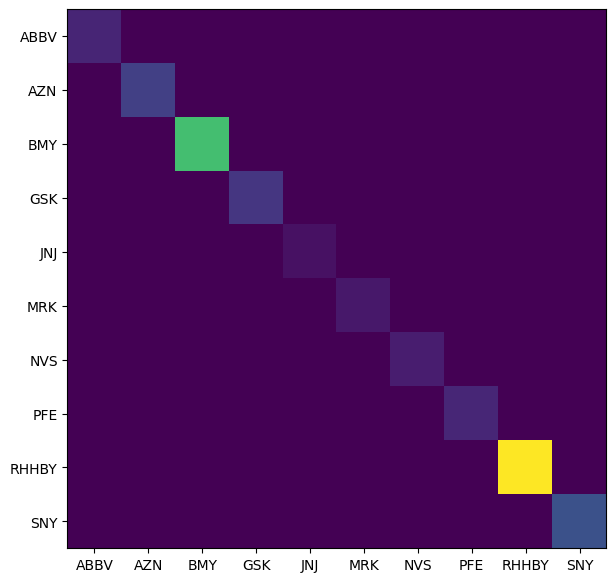

In [89]:
fig, ax = plt.subplots(figsize=(7,7))
im = ax.imshow(bl.omega)

# We want to show all ticks...
ax.set_xticks(np.arange(len(bl.tickers)))
ax.set_yticks(np.arange(len(bl.tickers)))

ax.set_xticklabels(bl.tickers)
ax.set_yticklabels(bl.tickers)
plt.show()

In [90]:
np.diag(bl.omega)
# Note how RHHBY, which we gave the lowest confidence, also has the highest uncertainty.

array([0.00180827, 0.00333966, 0.01244108, 0.00280307, 0.00078605,
       0.00112688, 0.00139006, 0.00189306, 0.01771065, 0.00437555])

### Calculate Posterior Estimate Returns

In [91]:
# We are using the shortcut to automatically compute market-implied prior
bl = BlackLittermanModel(S, pi="market", market_caps=mcaps, risk_aversion=delta,
                        absolute_views=viewdict, omega='idzorek', view_confidences=confidences)

In [92]:
# Posterior estimate of returns
ret_bl = bl.bl_returns()
ret_bl

Ticker
ABBV     0.059441
AZN      0.031216
BMY      0.108227
GSK      0.046788
JNJ      0.074052
MRK      0.087494
NVS     -0.032990
PFE      0.082980
RHHBY   -0.063645
SNY      0.048497
dtype: float64

In [93]:
rets_df = pd.DataFrame([market_prior, ret_bl, pd.Series(viewdict)],
             index=["Prior", "Posterior", "Views"]).T
rets_df

,Prior,Posterior,Views
ABBV,0.061355,0.059441,0.21
AZN,0.088911,0.031216,-0.05
BMY,0.078885,0.108227,0.18
GSK,0.077601,0.046788,0.10
JNJ,0.070500,0.074052,0.20
MRK,0.093364,0.087494,0.09
NVS,0.075812,-0.032990,-0.15
PFE,0.084773,0.082980,0.10
RHHBY,0.078030,-0.063645,-0.12
SNY,0.089170,0.048497,0.07


<Axes: >

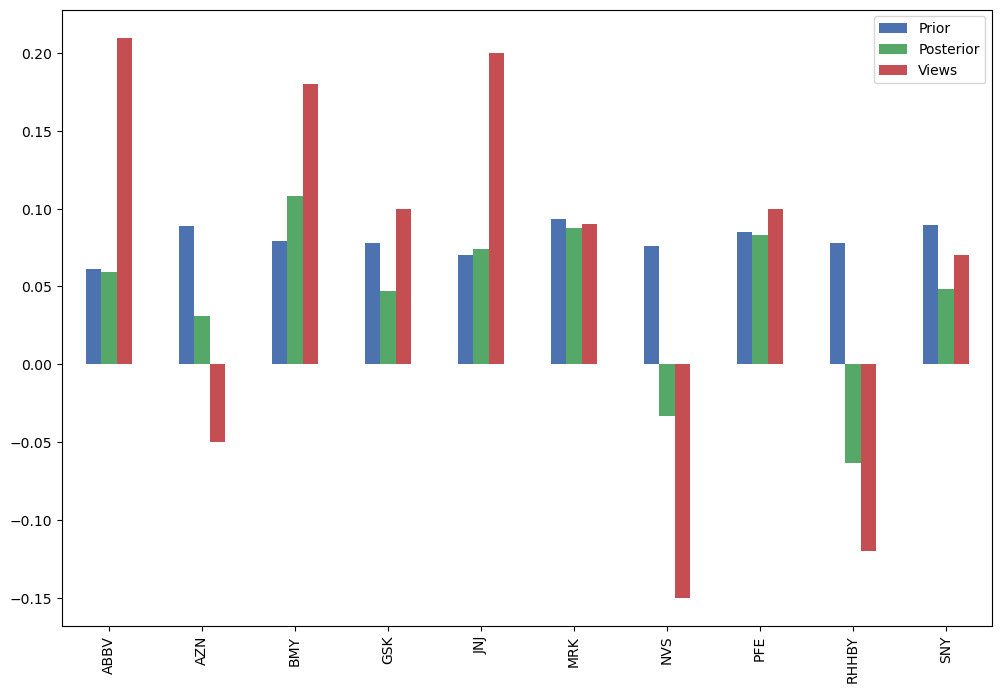

In [94]:
rets_df.plot.bar(figsize=(12,8))

Ticker      ABBV       AZN       BMY       GSK       JNJ       MRK       NVS  \
Ticker                                                                         
ABBV    0.040927  0.012467  0.015419  0.010730  0.011738  0.013535  0.011089   
AZN     0.012467  0.063896  0.024194  0.032345  0.018139  0.025163  0.026276   
BMY     0.015419  0.024194  0.057227  0.020592  0.019135  0.026913  0.018518   
GSK     0.010730  0.032345  0.020592  0.045482  0.017302  0.023813  0.023602   
JNJ     0.011738  0.018139  0.019135  0.017302  0.029922  0.022734  0.015456   
MRK     0.013535  0.025163  0.026913  0.023813  0.022734  0.063462  0.021183   
NVS     0.011089  0.026276  0.018518  0.023602  0.015456  0.021183  0.038537   
PFE     0.014369  0.025514  0.027236  0.022643  0.021875  0.030634  0.020912   
RHHBY   0.009152  0.026634  0.017582  0.022916  0.014876  0.019684  0.027302   
SNY     0.011262  0.033933  0.024861  0.030895  0.019877  0.027000  0.028995   

Ticker       PFE     RHHBY       SNY  


<Axes: >

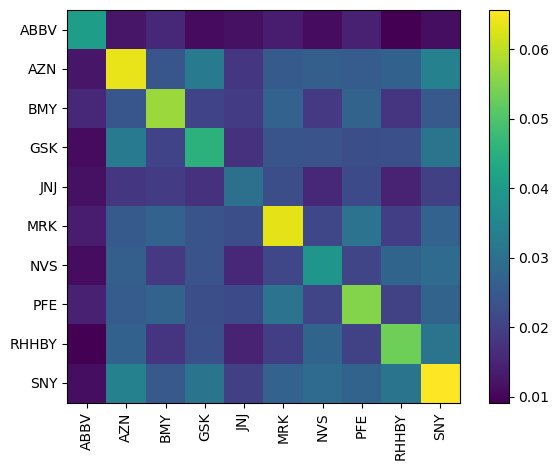

In [95]:
S_bl = bl.bl_cov()
print(S_bl)
plotting.plot_covariance(S_bl)

### Portfolio allocation

In [96]:
ef = EfficientFrontier(ret_bl, S_bl)

# A regularization term added to the optimization objective to improve the stability and robustness 
# of the optimized portfolio by penalizing extreme portfolio weights
ef.add_objective(objective_functions.L2_reg)

ef.max_sharpe()
weights = ef.clean_weights()
weights

c:\Users\JoyChang\anaconda3\Lib\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


OrderedDict([('ABBV', 0.10886),
             ('AZN', 0.01165),
             ('BMY', 0.24895),
             ('GSK', 0.06284),
             ('JNJ', 0.15084),
             ('MRK', 0.18264),
             ('NVS', 0.0),
             ('PFE', 0.17014),
             ('RHHBY', 0.0),
             ('SNY', 0.06408)])

<Axes: >

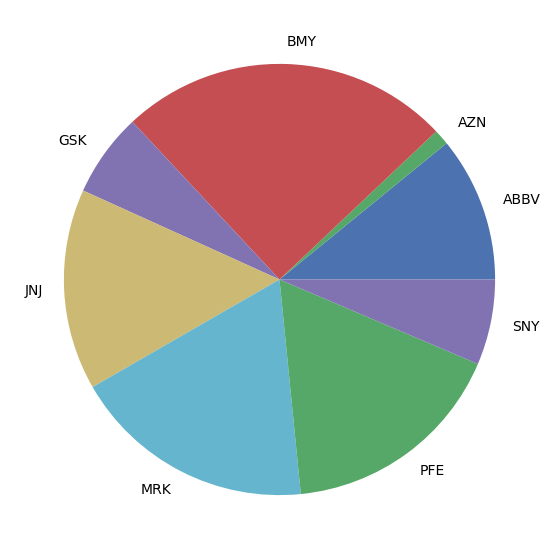

In [97]:
pd.Series(weights).plot.pie(figsize=(7,7))

c:\Users\JoyChang\anaconda3\Lib\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


Expected annual return: 8.1%
Annual volatility: 16.5%
Sharpe Ratio: 0.37


c:\Users\JoyChang\anaconda3\Lib\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  warnings.warn(


(0.08109356275161375, 0.16475909101341218, 0.3708054127747065)

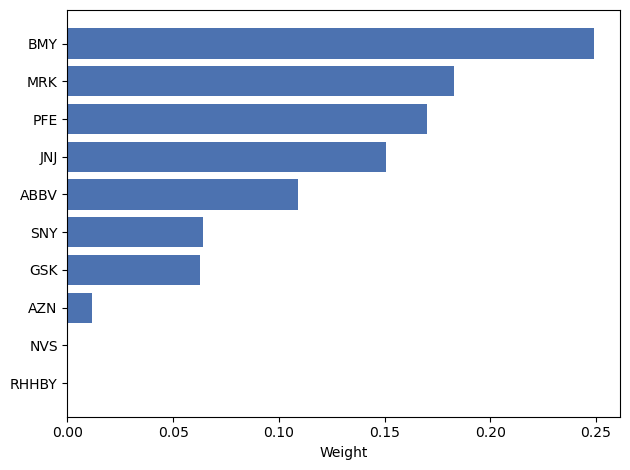

In [98]:
from pypfopt.plotting import plot_weights

# Maximum Sharpe
ef = EfficientFrontier(ret_bl, S_bl)
ef.add_objective(objective_functions.L2_reg)
ef.max_sharpe()
weights = ef.clean_weights()

plot_weights(weights)
ef.portfolio_performance(verbose = True, risk_free_rate = 0.009)

In [99]:
import torch

In [100]:
# Extract the posterior estimate returns from the Black-Litterman model
exp_returns = ret_bl.values
cov_matrix = S_bl.values

# Convert the posterior returns to a torch tensor
exp_returns_tensor = torch.Tensor(exp_returns).float()
cov_matrix_tensor = torch.Tensor(cov_matrix).float()

In [101]:
# May revise pricing_model.py by adding the following
class neuralized_heston(nn.Module):
    def __init__(self, device='cpu'):
        super(neuralized_heston, self).__init__()
        self.heston = heston()
        self.param_LSTM = param_LSTM(device)
        self.device = device
        self.to(device)
    
    def forward(self, params, exp_returns, cov_matrix):
        # Forward propagation
        # params: Other parameters needed for calculations
        # exp_returns: Expected returns obtained from Black-Litterman
        # cov_matrix: Covariance matrix obtained from Black-Litterman

        # Pass params through LSTM model to obtain processed parameters
        processed_params = self.param_LSTM(params)

        # Integrate processed parameters, expected returns, and covariance matrix into Heston model
        # Here you can modify the heston_predictions function to incorporate the additional inputs
        heston_output = self.heston(processed_params, exp_returns, cov_matrix)
        return heston_output

NameError: name 'nn' is not defined